In [332]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn import set_config

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [333]:
df_credit_card = pd.read_csv(r'C:\Users\jaraneses\OneDrive - 2X LLC\Codes\Portfolio Projects_storage\Day 35 - Credit Card Approval using Clustering\application_record.txt')
df = df_credit_card.copy()

In [334]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [335]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [336]:
df = df.dropna()

In [337]:
df.shape

(304354, 18)

In [338]:
df.duplicated().any()

np.False_

In [339]:
df.describe()

# 19 children? might need to cap until 5 or 6
# Amount income: 6.75M is huge need to check
# negative values of days of birth might be derived by subtracting the days before today 
# unrealistic for days employed 
# no variance for FLAG_MOBIL can be dropped as everyone has one
# cnt fam members can't have 20 or larger might to downsize it to 10

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,3.043540e+05,304354.000000,3.043540e+05,304354.000000,304354.000000,304354.0,304354.000000,304354.000000,304354.000000,304354.000000
mean,6.022984e+06,0.510977,1.948680e+05,-14806.806485,-2621.933357,1.0,0.248152,0.285559,0.117534,2.297985
std,5.698275e+05,0.765500,1.169721e+05,3487.223150,2400.254918,0.0,0.431941,0.451681,0.322056,0.926043
min,5.008806e+06,0.000000,2.700000e+04,-24770.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.617726e+06,0.000000,1.350000e+05,-17439.000000,-3508.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047822e+06,0.000000,1.800000e+05,-14583.000000,-1917.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.449036e+06,1.000000,2.250000e+05,-11944.000000,-919.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,-12.000000,1.0,1.000000,1.000000,1.000000,20.000000


In [340]:
df['AGE'] = abs(df['DAYS_BIRTH']) / 365
df['YEARS_EMPLOYED'] = abs(df['DAYS_EMPLOYED']) / 365

In [341]:
df[df['CNT_CHILDREN'] > 6].describe()
# unreasonable high mean for cnt_children 
# since this is all is just little fraction of the whole dataset, will just drop these

df = df[df['CNT_CHILDREN'] <= 6]

In [342]:
df.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED
count,3.043320e+05,304332.000000,3.043320e+05,304332.000000,304332.000000,304332.0,304332.000000,304332.000000,304332.000000,304332.000000,304332.000000,304332.000000
mean,6.022997e+06,0.510301,1.948676e+05,-14806.741039,-2621.946877,1.0,0.248143,0.285570,0.117543,2.297307,40.566414,7.183416
std,5.698121e+05,0.760888,1.169735e+05,3487.301260,2400.307017,0.0,0.431936,0.451686,0.322066,0.922294,9.554250,6.576184
min,5.008806e+06,0.000000,2.700000e+04,-24770.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000,20.517808,0.032877
25%,5.617739e+06,0.000000,1.350000e+05,-17439.000000,-3508.000000,1.0,0.000000,0.000000,0.000000,2.000000,32.723288,2.517808
50%,6.047836e+06,0.000000,1.800000e+05,-14582.000000,-1917.000000,1.0,0.000000,0.000000,0.000000,2.000000,39.950685,5.252055
75%,6.449034e+06,1.000000,2.250000e+05,-11944.000000,-919.000000,1.0,0.000000,1.000000,0.000000,3.000000,47.778082,9.610959
max,7.999952e+06,5.000000,6.750000e+06,-7489.000000,-12.000000,1.0,1.000000,1.000000,1.000000,7.000000,67.863014,48.030137


In [343]:
df[df['AMT_INCOME_TOTAL'] == df['AMT_INCOME_TOTAL'].max()]
# duplicated value, will drop.

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED
228159,5987963,M,Y,N,0,6750000.0,Working,Higher education,Married,House / apartment,-19341,-443,1,1,1,0,Laborers,2.0,52.989041,1.213699
228160,5987964,M,Y,N,0,6750000.0,Working,Higher education,Married,House / apartment,-19341,-443,1,1,1,0,Laborers,2.0,52.989041,1.213699
228161,5987966,M,Y,N,0,6750000.0,Working,Higher education,Married,House / apartment,-19341,-443,1,1,1,0,Laborers,2.0,52.989041,1.213699
228162,5987967,M,Y,N,0,6750000.0,Working,Higher education,Married,House / apartment,-19341,-443,1,1,1,0,Laborers,2.0,52.989041,1.213699
228163,5987968,M,Y,N,0,6750000.0,Working,Higher education,Married,House / apartment,-19341,-443,1,1,1,0,Laborers,2.0,52.989041,1.213699
228164,5987969,M,Y,N,0,6750000.0,Working,Higher education,Married,House / apartment,-19341,-443,1,1,1,0,Laborers,2.0,52.989041,1.213699
421262,7987964,M,Y,N,0,6750000.0,Working,Higher education,Married,House / apartment,-19341,-443,1,1,1,0,Laborers,2.0,52.989041,1.213699


In [344]:
df = df[df['AMT_INCOME_TOTAL'] != df['AMT_INCOME_TOTAL'].max()]

In [345]:
df.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED
count,3.043250e+05,304325.000000,3.043250e+05,304325.000000,304325.000000,304325.0,304325.000000,304325.000000,304325.000000,304325.000000,304325.000000,304325.000000
mean,6.022992e+06,0.510313,1.947168e+05,-14806.636744,-2621.996997,1.0,0.248126,0.285553,0.117545,2.297314,40.566128,7.183553
std,5.698075e+05,0.760893,1.126708e+05,3487.273561,2400.311873,0.0,0.431926,0.451678,0.322070,0.922303,9.554174,6.576197
min,5.008806e+06,0.000000,2.700000e+04,-24770.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000,20.517808,0.032877
25%,5.617737e+06,0.000000,1.350000e+05,-17438.000000,-3508.000000,1.0,0.000000,0.000000,0.000000,2.000000,32.723288,2.517808
50%,6.047844e+06,0.000000,1.800000e+05,-14582.000000,-1917.000000,1.0,0.000000,0.000000,0.000000,2.000000,39.950685,5.252055
75%,6.449035e+06,1.000000,2.250000e+05,-11944.000000,-919.000000,1.0,0.000000,1.000000,0.000000,3.000000,47.775342,9.610959
max,7.999952e+06,5.000000,4.500000e+06,-7489.000000,-12.000000,1.0,1.000000,1.000000,1.000000,7.000000,67.863014,48.030137


Text(0.5, 1.0, 'Correlation among numerical features')

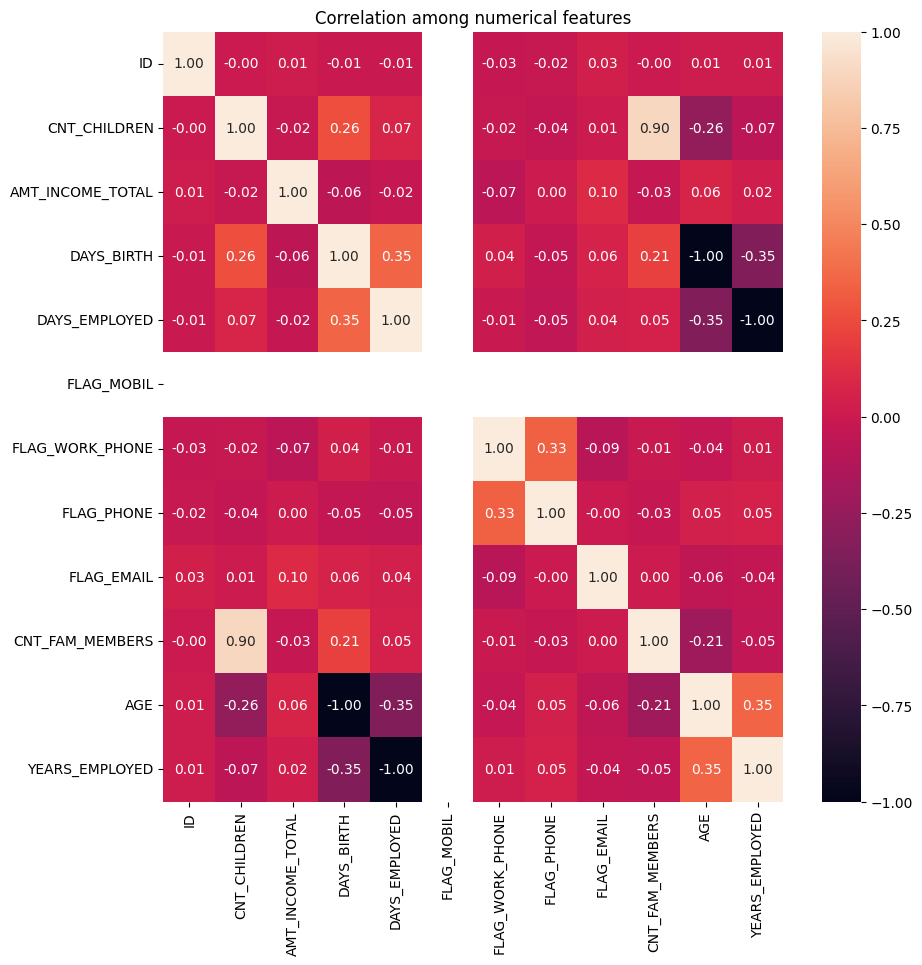

In [346]:
plt.figure(figsize= (10, 10))
sns.heatmap(df.corr(numeric_only= True), annot = True, fmt = '.2f')
plt.title('Correlation among numerical features')

# cnt members and cnt children has high correlation with each other (multicollinear)
# Flag phone and Flag workphone has moderate correlation with each other (multicollinear)
# Age and years employed has moderate correlation (older -- greater years of employment)
# age and cnt children has moderate negative correlation (young -- more number of children)
# flag_mobil will be dropped as anyone has it

In [347]:
df = df.drop(columns= ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'CNT_CHILDREN', 'ID'])

In [348]:
df.describe()

,AMT_INCOME_TOTAL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED
count,3.043250e+05,304325.000000,304325.000000,304325.000000,304325.000000,304325.000000,304325.000000
mean,1.947168e+05,0.248126,0.285553,0.117545,2.297314,40.566128,7.183553
std,1.126708e+05,0.431926,0.451678,0.322070,0.922303,9.554174,6.576197
min,2.700000e+04,0.000000,0.000000,0.000000,1.000000,20.517808,0.032877
25%,1.350000e+05,0.000000,0.000000,0.000000,2.000000,32.723288,2.517808
50%,1.800000e+05,0.000000,0.000000,0.000000,2.000000,39.950685,5.252055
75%,2.250000e+05,0.000000,1.000000,0.000000,3.000000,47.775342,9.610959
max,4.500000e+06,1.000000,1.000000,1.000000,7.000000,67.863014,48.030137


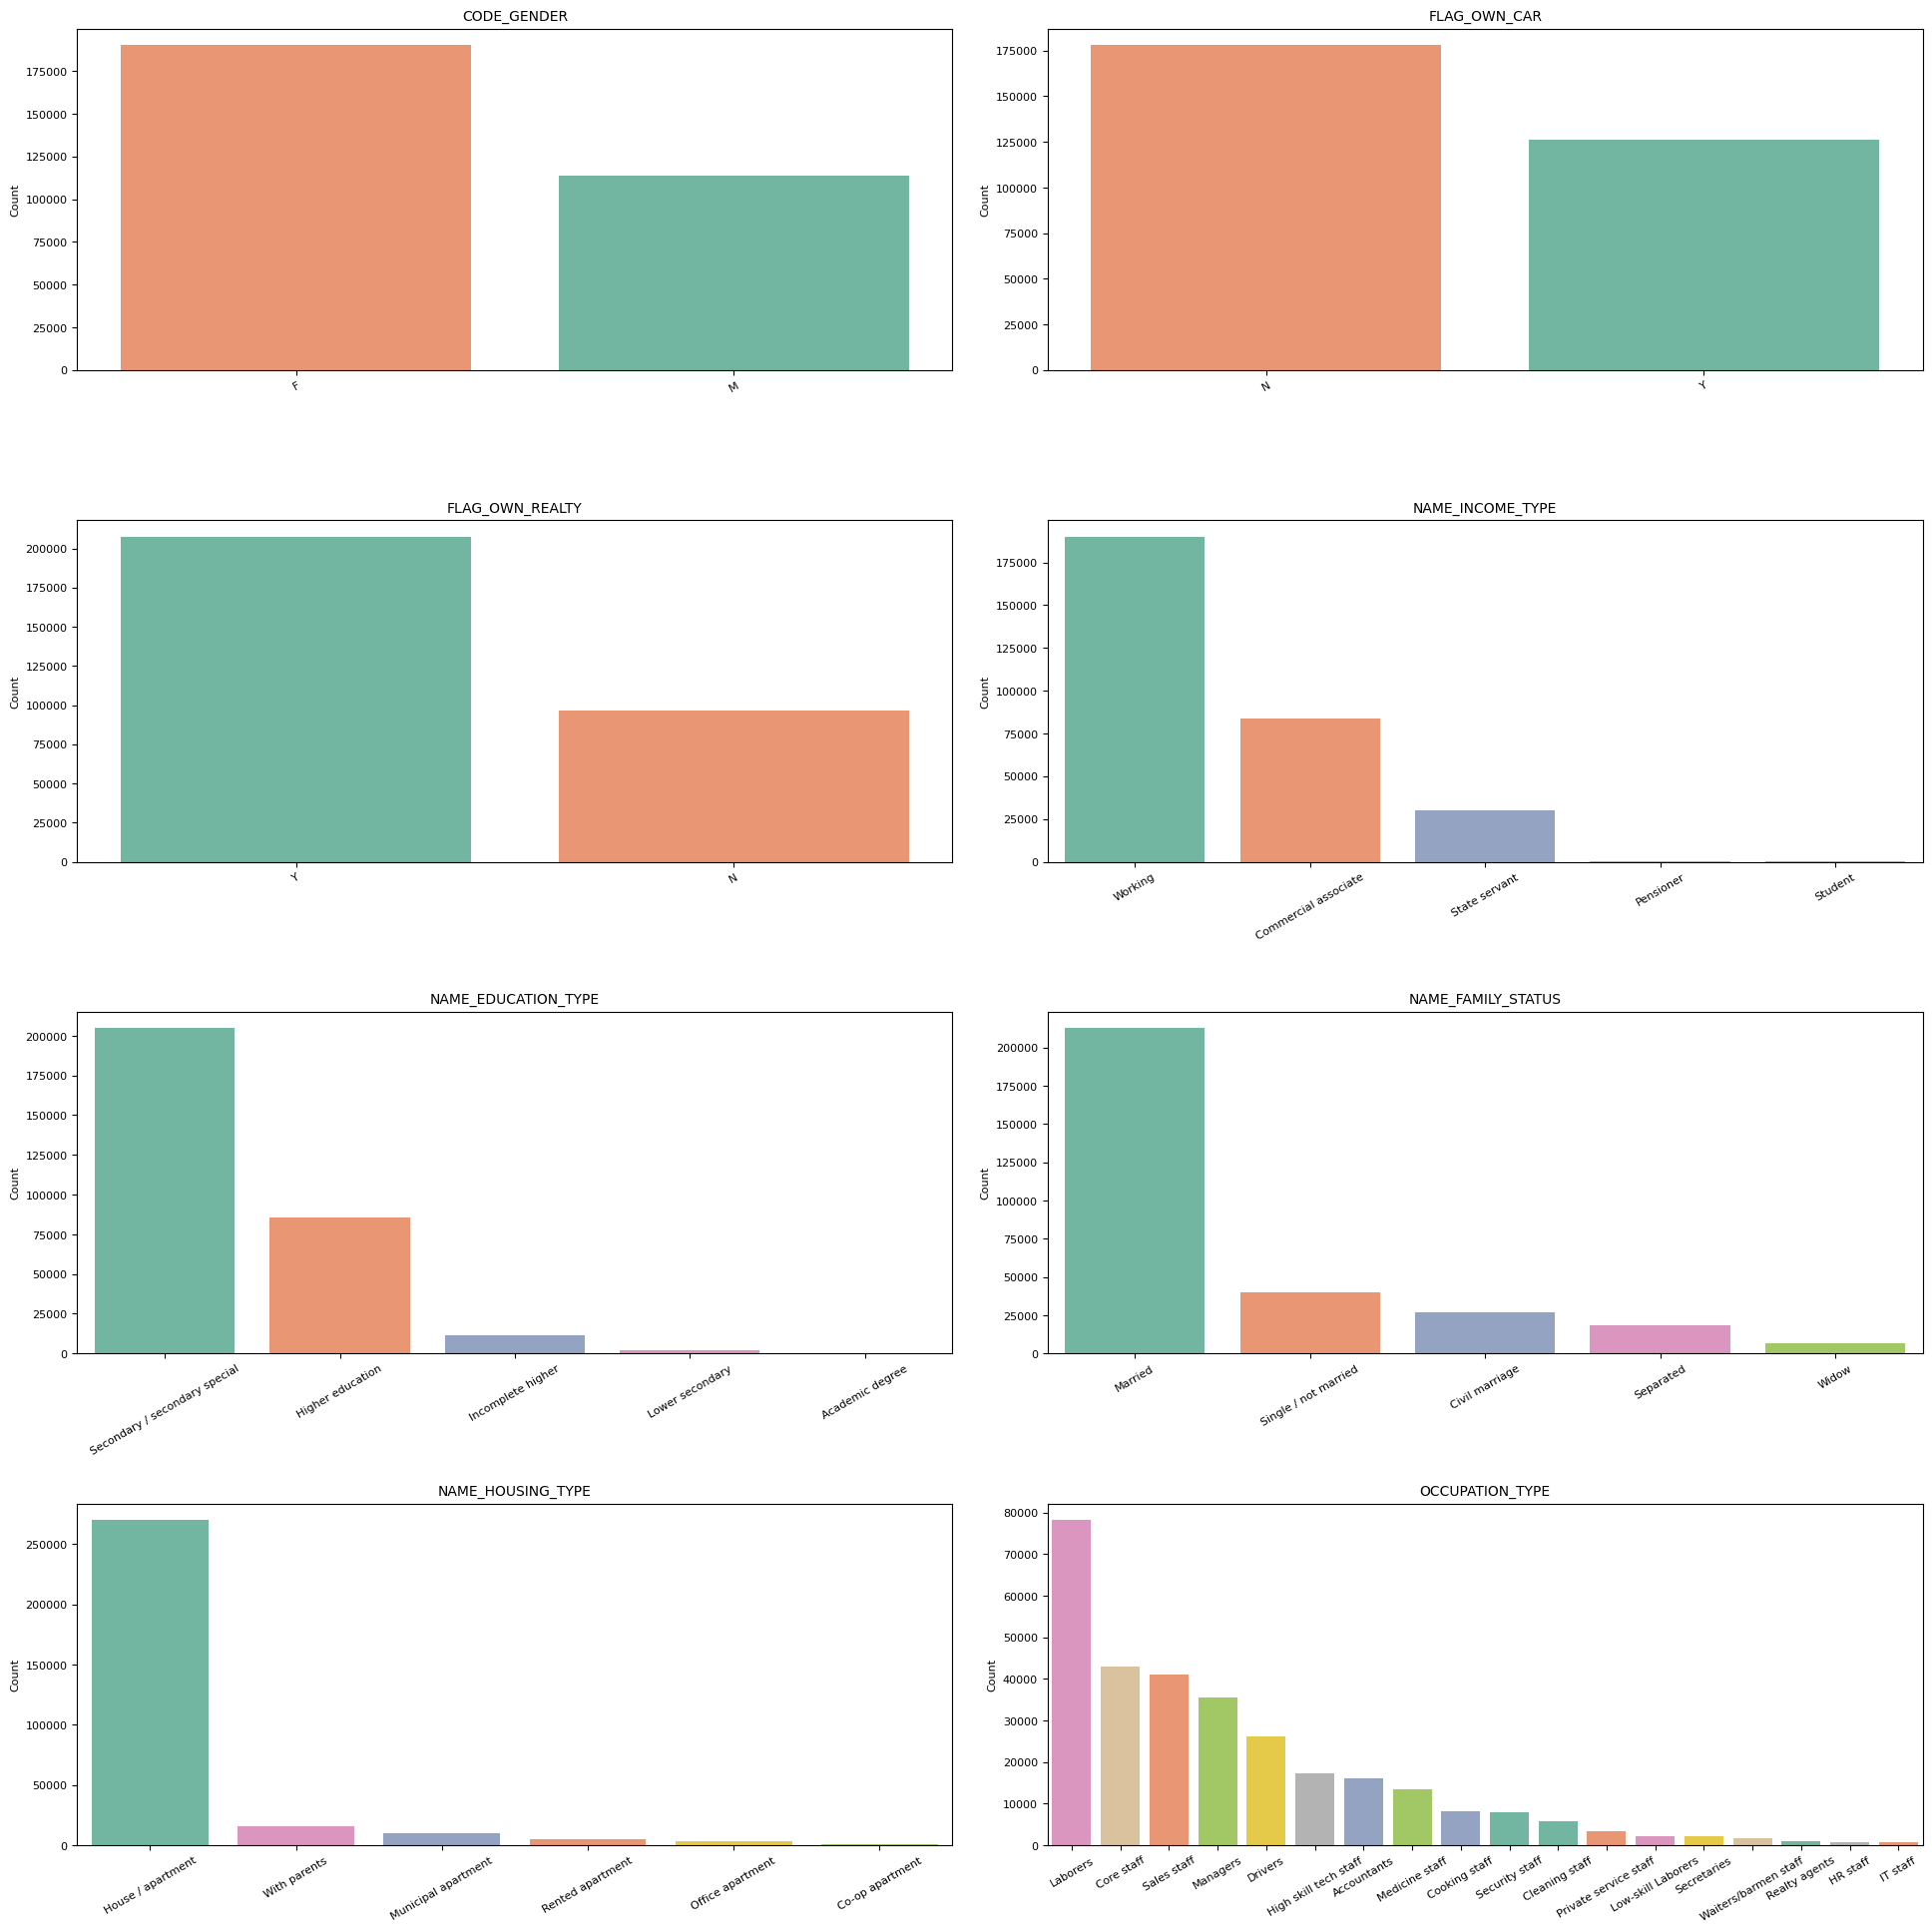

In [349]:
obj_cols = list(df.select_dtypes(include= 'object'))

fig, axes = plt.subplots(4,2, figsize= (20, 20))
axes = axes.flatten()

for i, cols in enumerate(obj_cols): 
    sns.countplot(x = cols, 
                  data = df,
                  order=df[cols].value_counts().index,
                  ax = axes[i],
                  palette = "Set2",
                  legend=False,
                  hue = cols)
    axes[i].set_title(f"{cols}", fontsize=10)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count", fontsize=8)
    axes[i].tick_params(axis='x', rotation=30, labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)

plt.tight_layout(pad=3.0, h_pad=2.0, w_pad=2.0)

In [350]:
set_config(display='text')
ONEHOT_THRESHOLD = 5    

num_cols = df.select_dtypes(['int64', 'float64']).columns.to_list()
obj_cols = list(df.select_dtypes(include= 'object'))

onehot_cols = [c for c in obj_cols if df[c].nunique(dropna=True) <= ONEHOT_THRESHOLD]
ordinal_cols = [c for c in obj_cols if df[c].nunique(dropna=True) > ONEHOT_THRESHOLD]

In [351]:
scaler = RobustScaler()
onehot = OneHotEncoder(handle_unknown= 'ignore', drop= 'first', sparse_output= False)
ordinal = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [352]:
ct = ColumnTransformer(
    transformers= [
        ('num', scaler, num_cols),
        ('ohe', onehot, onehot_cols),
        ('ord', ordinal, ordinal_cols)
    ],
    remainder= 'drop',
    sparse_threshold= 0
)

print(ct)

ColumnTransformer(sparse_threshold=0,
                  transformers=[('num', RobustScaler(),
                                 ['AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE',
                                  'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
                                  'AGE', 'YEARS_EMPLOYED']),
                                ('ohe',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['CODE_GENDER', 'FLAG_OWN_CAR',
                                  'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
                                  'NAME_EDUCATION_TYPE',
                                  'NAME_FAMILY_STATUS']),
                                ('ord',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
     

In [353]:
ct.fit(df)

X_trans = ct.transform(df)

feature_names = ct.get_feature_names_out()
X_df = pd.DataFrame(X_trans, columns= feature_names, index = df.index)

print(X_df.shape)
X_df.head()



(304325, 24)


,num__AMT_INCOME_TOTAL,num__FLAG_WORK_PHONE,num__FLAG_PHONE,num__FLAG_EMAIL,num__CNT_FAM_MEMBERS,num__AGE,num__YEARS_EMPLOYED,ohe__CODE_GENDER_M,ohe__FLAG_OWN_CAR_Y,ohe__FLAG_OWN_REALTY_Y,...,ohe__NAME_EDUCATION_TYPE_Higher education,ohe__NAME_EDUCATION_TYPE_Incomplete higher,ohe__NAME_EDUCATION_TYPE_Lower secondary,ohe__NAME_EDUCATION_TYPE_Secondary / secondary special,ohe__NAME_FAMILY_STATUS_Married,ohe__NAME_FAMILY_STATUS_Separated,ohe__NAME_FAMILY_STATUS_Single / not married,ohe__NAME_FAMILY_STATUS_Widow,ord__NAME_HOUSING_TYPE,ord__OCCUPATION_TYPE
2,-0.75,0.0,0.0,0.0,0.0,1.254459,-0.302433,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,16.0
3,1.00,0.0,1.0,1.0,-1.0,0.824172,0.438007,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,14.0
4,1.00,0.0,1.0,1.0,-1.0,0.824172,0.438007,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,14.0
5,1.00,0.0,1.0,1.0,-1.0,0.824172,0.438007,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,14.0
6,1.00,0.0,1.0,1.0,-1.0,0.824172,0.438007,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,14.0


In [354]:
# determine if PCA is needed,
print(X_df.shape) # PCA needs to have 100+ columns
(X_df.corr().abs().mean().mean()) # low correlation

(304325, 24)


np.float64(0.09263125706808657)

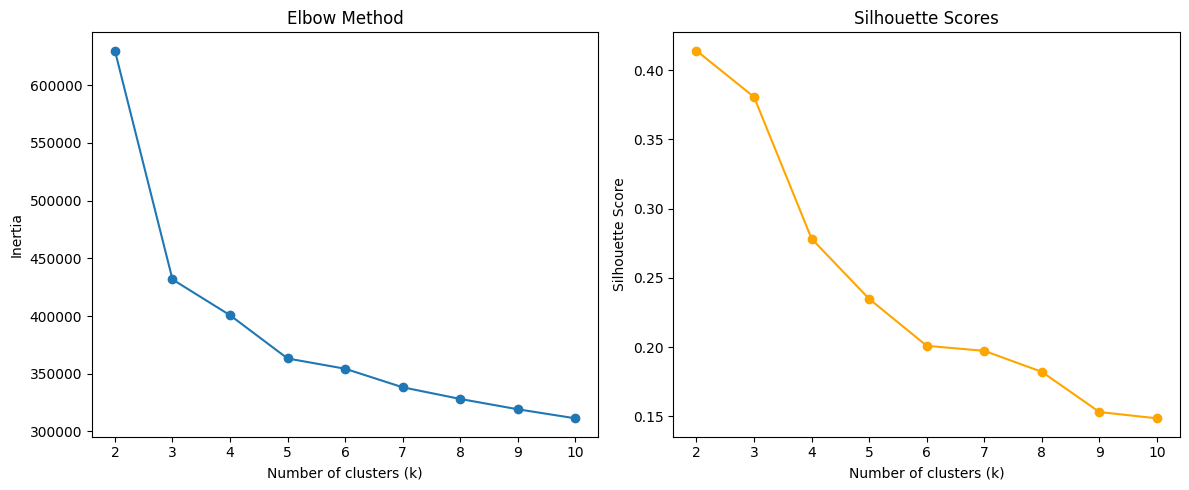

In [355]:
inertia = []
sil_scores = []
K = range(2, 11)
sample_X = X_df.sample(50000, random_state=42)


for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(sample_X)
    inertia.append(model.inertia_)
    sil_scores.append(silhouette_score(sample_X, labels))


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K, sil_scores, marker='o', color='orange')
plt.title("Silhouette Scores")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

In [356]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_df)

X_df['Cluster'] = clusters

In [366]:
df['Cluster'] = X_df['Cluster']

numeric_cols = ['AMT_INCOME_TOTAL', 'AGE', 'YEARS_EMPLOYED', 
                'CNT_FAM_MEMBERS', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']

cluster_numeric_summary = df.groupby('Cluster')[numeric_cols].mean().round(2)
cluster_numeric_summary



,AMT_INCOME_TOTAL,AGE,YEARS_EMPLOYED,CNT_FAM_MEMBERS,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL
Cluster,,,,,,,
0,172906.30,39.61,5.32,2.26,0.26,0.28,0.11
1,192396.21,40.52,7.10,2.32,0.25,0.30,0.12
2,204772.91,40.97,7.97,2.30,0.24,0.28,0.12


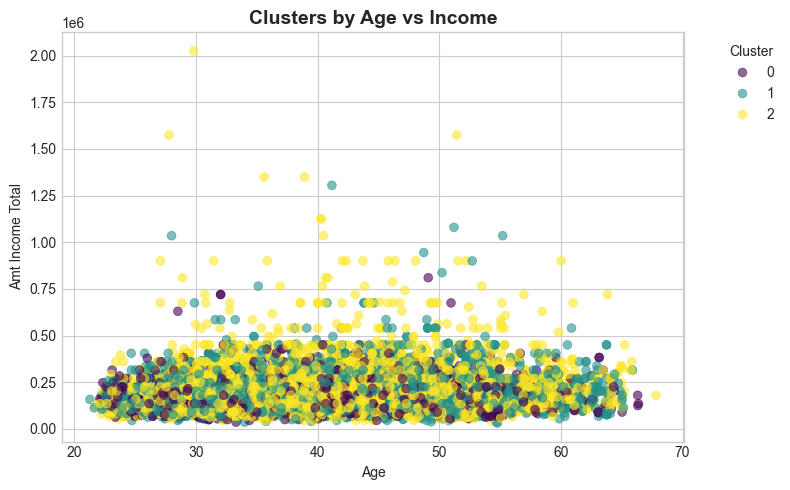

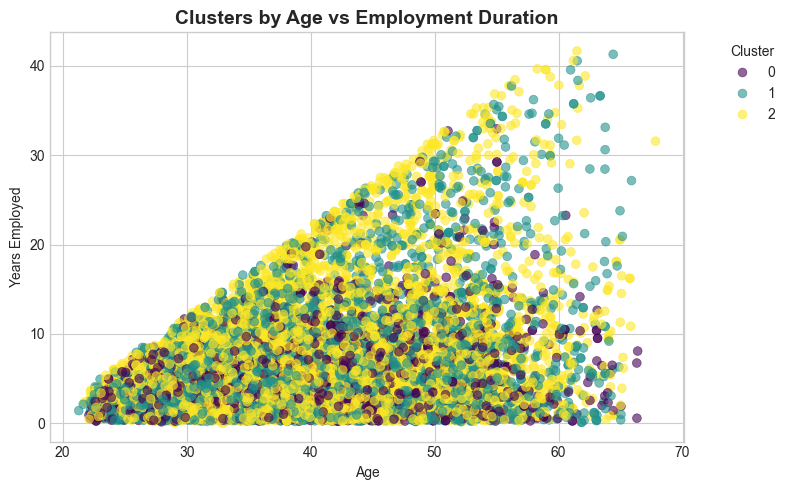

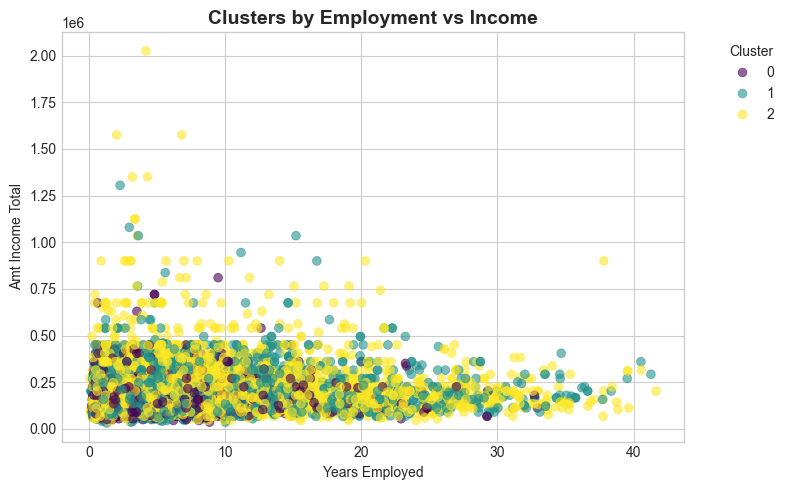

In [372]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')

features = [
    ('AGE', 'AMT_INCOME_TOTAL', 'Age vs Income'),
    ('AGE', 'YEARS_EMPLOYED', 'Age vs Employment Duration'),
    ('YEARS_EMPLOYED', 'AMT_INCOME_TOTAL', 'Employment vs Income')
]

for x, y, title in features:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=df.sample(10000, random_state=42),  # Sample for clarity
        x=x,
        y=y,
        hue='Cluster',
        palette='viridis',  # modern color palette
        alpha=0.6,
        s=40,
        edgecolor=None
    )
    plt.title(f'Clusters by {title}', fontsize=14, weight='bold')
    plt.xlabel(x.replace('_', ' ').title())
    plt.ylabel(y.replace('_', ' ').title())
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [363]:
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(X_df.drop('Cluster', axis=1), X_df['Cluster'])
print(f"Davies-Bouldin Score: {db_score:.4f}")


Davies-Bouldin Score: 0.9438


I used K-Means clustering to identify three groups of applicants based on age, income, and years of employment.
The scatterplot shows that green points represent older applicants with higher income and more years of work experience — our established professionals.
Orange represents mid-career earners, and blue represents younger, early-career individuals with lower income and shorter employment histories.
This segmentation helps us understand different customer profiles and tailor financial strategies for each group